<span style="font-size:10pt">Robotics & AI workshop @ PPU – June 2022 – Jean-Luc Charles (Jean-Luc.charles@ensam.eu) – CC BY-SA 4.0 – v1.0</span>

# Train a Dense Neural Network (DNN) for the classification of handwritten digits images

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:14pt"> 
It is important to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for main Python projects: a PVE makes it possible to control for each project the versions of the Python interpreter and the "sensitive" modules (like tensorflow).</span></div>

All the notebooks in this directory must be loaded into a `jupyter notebook` launched in the PVE <b><span style="color: rgb(200, 151, 102);" >pyml</span></b> specially created for the workshop.<br>
They must be worked in this order:
- `ML1_MNIST.ipynb`: check that the <b><span style="color: rgb(200, 151, 102);">pyml</span></b> EVP is fully operationnal, load and use the data from the MNIST database (images and labels).
- `ML2_DNN.ipynb`: build a Dense Neural Network, train it with data from the MNIST and evaluate its performance.
- `ML3_DNN_ipynb`: re-load a trained DNN and evaluate its performnce with MNIST test data.
- `ML4_CNN.ipynb`: build a Convolutional Neural Network, train it with the MNIST database, ebvaluate its performance and use it with test data.

**Targeted learning objectives**
- Know how to build a Dense Neural Network with the Python modules **tensorflow** and **keras**.
- Know how to train a DNN with data from the MNIST.
- Know how to display training performance curves.
- Know how to save the structure and the weights of the trained network.

## Check Python modules
The **keras** module which allows high-level manipulation of **tensorflow** objects is integrated in the **tensorflow** (tf) module since version 2. <br>
The **tf.keras** module documentation to consult for this APP is here: [www.tensorflow.org/api_docs/python/tf/keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In [1]:
import os
print(f"Working directory: {os.getcwd()}")

Working directory: /home/jlc/work/Cours/ROS/github.com_cjlux/Robotics-AI-training-at-PPU/3-Machine_Learning_training/Classification/Notebooks/Correction


Delete the (numerous) warning messages from the **tensorflow** module:

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys, cv2
import matplotlib.pyplot as plt
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.6.12
tensorflow: 2.6.0 incluant keras 2.6.0
numpy     : 1.19.2
OpenCV    : 4.6.0


Embedding matplotlib plots in the notebook:

In [4]:
%matplotlib inline

# Structure of the DNN

In this notebook we will build a **Dense Neural Network** , with:
- an **input layer** of 784 values between 0 and 1 (the pixels of the MNIST 28 $\times$ 28 images flattened to a normalized vector of 784 `float` numbers),
- a **hidden layer** of 784 neurons with the `relu` activation function,
- an **output layer** of 10 neurons for the classification of images into 10 classes associated with the digits {0,1,2...9}, using the `softmax` activation function adapted to classification problems.
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/archiReseau.png" alt="archiReseau.png" style="width: 900px;"><br> 
    [crédit image : JLC]
</p>

Remarks :
- Each neuron of the first hidden layer receives 785 inputs: the 784 values $x_i$ of the pixels of the image plus the bias.
- $\leadsto$ There are 785 unknown parameters for each neuron: the 784 weights $w_i$ assigned to each input $x_i$, plus the weight $b$ assigned to input $-1$.
- $\leadsto$ there are 785 $\times$ 784 unknown parameters for the hidden layer and 785 $\times$ 10 unknown parameters for the output layer: i.e. a total of 623290 unknown parameters whose value must be optimized by the supervide training of the DNN.

## Work to do
### 1 - Load MNIST images and set important parameters<br>2 - Pre-process MNIST images and labels<br>3 - Create the neural network<br>4 - A first attempt to train the network <br>5 - Train the network while evaluating its performance at every *epoch*<br>6 - Train the network while evaluating its performance at every *epoch* and managing the *over-fit*<br>7 - Save the trained DNN

## 1 - Load MNIST images and define important parameters

The work of loading MNIST images has been explained in the *notebook* `ML1_MNIST.ipynb`:

In [5]:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()
print("im_train -> shape:", im_train.shape, ", dtype:", im_train.dtype,)
print("im_test  -> shape:", im_test.shape,  ", dtype:", im_test.dtype,)
print("lab_train-> shape:", lab_train.shape,  ", dtype:", lab_train.dtype)
print("lab_test -> shape:", lab_test.shape,  ", dtype:", lab_test.dtype)

im_train -> shape: (60000, 28, 28) , dtype: uint8
im_test  -> shape: (10000, 28, 28) , dtype: uint8
lab_train-> shape: (60000,) , dtype: uint8
lab_test -> shape: (10000,) , dtype: uint8


#### Set important parameters

To avoid "hard-coding" the **number of training and test images**, the **dimension** of the images and the **number of classes**, these parameters are retrieved thanks to to existing object attributes:
- the `shape` attribute of the `im_train` and `im_test` arrays contains the number of training and test images,
- the `size` attribute of the first training (or test) image gives the number of pixels of the images (784),<br>
- converting the `lab_test` array into a Python `set` gives the set of labels to recognize, whose size is the number of classes.

Complete the cell below:

In [6]:
nb_im_train = im_train.shape[0]    # number of train images
nb_im_test  = im_test.shape[0]     # number of test images
nb_pixel    = im_train[0].size     # number of pixels par iamge
nb_class   = len(set(lab_test))   # number of classes (10 digits from 0 to 9)

Checking:

In [7]:
print(f"{nb_im_train} train images and {nb_im_test} test images")
print(f"{nb_pixel} pixels in each image")
print(f"{nb_class} classes (the digits from 0 to 9)")

60000 train images and 10000 test images
784 pixels in each image
10 classes (the digits from 0 to 9)


## 2 - Pre-processing of MNIST images and labels

Two treatments must be applied to the MNIST data set:
- on the images: transform the matrices of `uint8` integers representing the images 28$\,\times\,$28 pixels into **normalized** vectors $(V_i)_{i=0..783}$ of 784 real values $V_i$ with $ 0 \leqslant V_i \leqslant 1$;
- on labels: transform scalar numbers into *one-hot* vectors.

### Transform input matrices into normalized vectors

Define the arrays `x_train` and `x_test` containing respectively all the data of the `im_train` and `im_test` arrays *flattened* to normalized vectors (values between 0 and 1).<br>
*tips*:
- use the `reshape` method of the of the *numpy* *ndarray* and the `nb_im_train`, `nb_im_test` and `nb_pixel` parameters previously defined,
- normalization can be handled by dividing arrays by their max value.

In [8]:
x_train = im_train.reshape(nb_im_train, nb_pixel)/im_train.max()
x_test  = im_test.reshape(nb_im_test, nb_pixel)/im_test.max()

Check the dimensions of `x_train` and `x_test` arrays as well as their *min* and *max* values:

In [9]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [10]:
(x_train.min(), x_train.max()) == (0, 1)

True

In [11]:
(x_test.min(), x_test.max()) == (0, 1)

True

###  encoding the labels in *one-hot* vectors:

Consult the documentation on the `to_categorical` function on the page [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) and deduce how to define the `y_train` and `y_test` arrays containing the *hot-one* encoded version of the `lab_train` and `lab_test` arrays:

In [12]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Visually check the first 10 values of the `lab_train` and `y_train` arrays:

In [13]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 3 - Build the DNN

Now we build a dense **sequential** neural network in **5 lines** using the **keras** module.

Build the network incrementally in the cell below, following the proposed approach (see the page [guide/keras/sequential_model](https://www.tensorflow.org/guide/keras/sequential_model ) if necessary) :
- 1/ Create the object `model` instance of the `Sequential` class  (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).
- 2/ With the `add` method of the `model` object add:
    - the input layer `Input(shape=<number of neurons>)` (cf [tf.keras.layers.Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) )<br>
    Use the `nb_pixel` parameter to specify the value of the `shape` parameter (which must be a `tuple`)...<br>
    - the intermediate dense layer (cf [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)): `Dense(<number of neurons>, activation='relu')` (cf [tf.keras.activation.relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu))
    - the output dense layer: `Dense(<number of neurons>, activation='softmax')` (cf [tf.keras.activation.softmax](https://www.tensorflow.org/api_docs/python/tf /keras/activations/softmax)).<br>
Use the `nb_pixel` and `nb_class` parameters to indicate the number of neurons and the number of classes without 'hard coding' them...
- 3/ Once built, the network must be compiled (in the sense of tensorflow) with the `compile` method and the arguments:
    - `loss='categorical_crossentropy'`: choice of the error function (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
    - `optimizer='adam'`: choice of Adam optimizer (see page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) )
    - `metrics=['accuracy']` to obtain training statistics to draw performance curves.

In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed of the random generators inolved by tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

# the 5 lines to build a DNN with keras:
model = Sequential()
model.add(Input(shape=(nb_pixel,), name='Input'))
model.add(Dense(nb_pixel, activation='relu', name='C1'))
model.add(Dense(nb_class, activation='softmax', name='C2'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

*Note*: By using the `name` argument in the `Input` and `Dense` constructors, oyou can give custom names to the layers, which will appear in the outputs of `summary` and `plot_model`.

With the `summary` method of the `model` object, display the description of the model and check the dimensions...

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Dense)                   (None, 784)               615440    
_________________________________________________________________
C2 (Dense)                   (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


Why are there `None` in the "Output Shape" column?

Find the total number of parameters with a simple formula...

In [16]:
785*784+785*10

623290

The `plot_model` function draws the structure of the network (see the page [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)). <br>
Plot the model structure by adding the `show_shapes=True` option to the `plot_model` call:<br><br>

*Nota*: If you get an error with Windows, open a terminal (the *prompt Anaconda* window)
- uninstall **pydot** with *pip* : `pip uninstall pydot`
- install **pydot** & **pydotplus** with *conda* : `conda install pydot pydotplos`

Restart and re-run the notebook kernel.

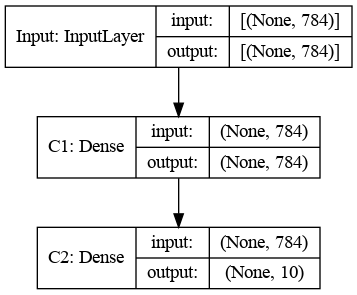

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Save the initial DNN state

We can save the initial values of the DNN weights (random values) with the `save_weights` method of the `Sequential` class. <br>
This will be useful later to reset the DNN to its initial state before restarting other trainings:

In [20]:
import os

# Check whether the folder 'weights' exists and cretae it if needed:
if not os.path.isdir("weights"): os.mkdir("weights")

# Save the initial DNN (random) weights:
key = 'dense-1_init'
model.save_weights(os.path.join('weights', key))

# Display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/dense-1_init.data-00000-of-00001
weights/dense-1_init.index


Note: the `save_weights` method uses the `key` argument to prefix the created files.<br>
When loading the NDD weights later with the `load_weights` method of the `Sequential` class, just give the same key to retrieve the relevant files.

## 4 - First network training 

If necessary, consult the documentation of the `fit` method on the page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Complete the cell below to train the DNN with the `fit` method of the `model` object using the arguments:
- `x_train`: the 60000 flattened and normalized images
- `y_train`: the 60000 *one-hot* encoded labels.
- `epochs=15`: repeat full training 15 times.
- `batch_size=128`: split the input data set (the 60000 images) into "batches" of size `batch_size` (here: batches of 128 images).<br>
Updating network weights is done after batches of `batch_size` images.<br>
The value of `batch_size` (by default: 32) is a parameter that influences the quality of the training but also its memory footprint: you can later try different values (64, 128, 256 ...) and observe how the quality of the training evolves).

In [21]:
# reload the initial state of the DNN
key = 'dense-1_init'
model.load_weights(os.path.join('weights', key)) 

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2479 - accuracy: 0.9292
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0981 - accuracy: 0.9712
Epoch 3/15
469/469 [==============================] - 2s 3ms/step - loss: 0.0616 - accuracy: 0.9818
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0430 - accuracy: 0.9872
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0305 - accuracy: 0.9911
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0219 - accuracy: 0.9938
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0154 - accuracy: 0.9963
Epoch 8/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0114 - accuracy: 0.9971
Epoch 9/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0095 - accuracy: 0.9977
Epoch 10/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0078 - accuracy: 0.9981

The `hist` object returned by the `fit` method has a `history` attribute of type `dict` whose keys `'loss'` and `'accuracy'` are associated with the corresponding data at each _epoch_:

In [22]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

In [23]:
hist.history['loss']

[0.24794550240039825,
 0.09809277206659317,
 0.061607666313648224,
 0.04299036040902138,
 0.030524561181664467,
 0.02185109443962574,
 0.015408381819725037,
 0.01143721118569374,
 0.009477878920733929,
 0.007791872601956129,
 0.006682214327156544,
 0.00984165072441101,
 0.006851618643850088,
 0.0032837926410138607,
 0.005042443983256817]

In [24]:
hist.history['accuracy']

[0.9292333126068115,
 0.9712333083152771,
 0.9817666411399841,
 0.9871500134468079,
 0.9910500049591064,
 0.9937999844551086,
 0.9962666630744934,
 0.9971166849136353,
 0.9976500272750854,
 0.998116672039032,
 0.9982666373252869,
 0.9968166947364807,
 0.9978333115577698,
 0.9993500113487244,
 0.9984666705131531]

### Drawing `loss` and `accuracy` curves

The `plot_loss_accuracy` function of the `utils.tools` module (found in the notebook directory) plots the "Model accuracy" and "Model loss" curves with the data stored in `hist`.<br> Import and use the `plot_loss_accuracy` function to plot these curves:

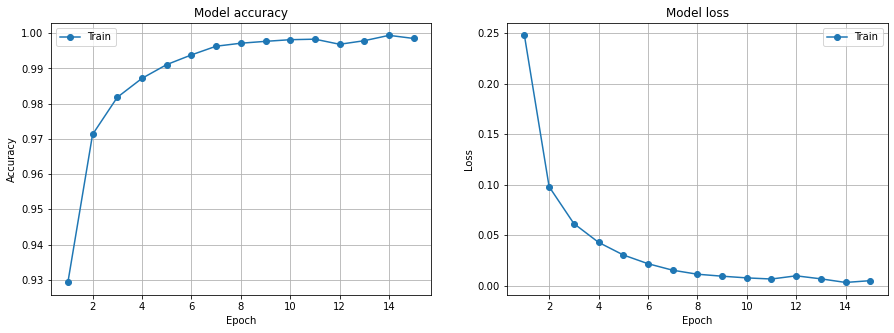

In [25]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 5 - Train the network while measuring its performance at each *epoch*

To have a better indicator of the quality of the trained network, you can test at each `epoch` the precision of the inferences of the trained network using the test data: just pass the `validation_data` argument to the `fit` method, assigning it the test data tuple `(x_test, y_test)`:

In [26]:
# reload the initial state of the DNN
key = 'dense-1_init'
model.load_weights(os.path.join('weights', key))

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=15, 
                 batch_size=128)

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1943 - accuracy: 0.9424 - val_loss: 0.0964 - val_accuracy: 0.9702
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0717 - accuracy: 0.9786 - val_loss: 0.0735 - val_accuracy: 0.9772
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0442 - accuracy: 0.9873 - val_loss: 0.0636 - val_accuracy: 0.9801
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.0609 - val_accuracy: 0.9803
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0589 - val_accuracy: 0.9812
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0545 - val_accuracy: 0.9828
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0576 - val_accuracy: 0.9834
Epoch 

Now the `hist.history` dictionnary has also the new keys `val_loss` and `val_accuracy` calculated with the test data:

In [27]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display these curves with the `plot_loss_accuracy` function:

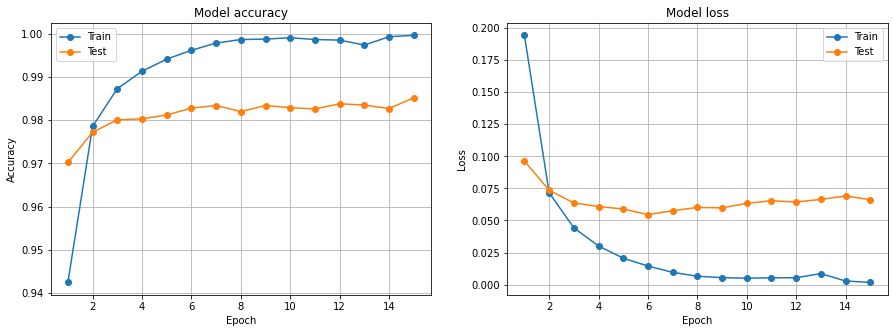

In [28]:
plot_loss_accuracy(hist)

the precision calculated with the test data tends towards a limit close to 98%. You might think that increasing the value of `epochs` would improve the precision of the network... but you run the risk of over-training the network (*over-fit*)...

## 6 - Train the network while measuring its performance at each *epoch* and managing the *over-fit*

The `Keras` module offers tools to automatically stop the training by monitoring, for example, the growth of precision from one `epoch` to another.
You define the parameters of the `EarlyStopping` (cf [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) *callback* and pass it to the method `fit` via the `callbacks` argument:

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1887 - accuracy: 0.9439 - val_loss: 0.0945 - val_accuracy: 0.9700
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0678 - accuracy: 0.9799 - val_loss: 0.0710 - val_accuracy: 0.9777
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0412 - accuracy: 0.9880 - val_loss: 0.0609 - val_accuracy: 0.9811
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0280 - accuracy: 0.9916 - val_loss: 0.0603 - val_accuracy: 0.9811
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0184 - accuracy: 0.9948 - val_loss: 0.0552 - val_accuracy: 0.9815
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.0544 - val_accuracy: 0.9826
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0565 - val_accuracy: 0.9834
Epoch 

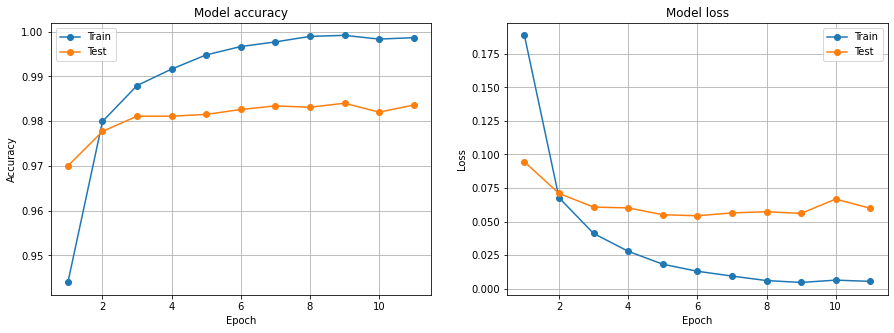

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_accuracy',  # the parameter to monitor
                  mode='max',              # the parameter is suppose to increse
                  patience=2,              # accept that the parameter decreases twice
                  restore_best_weights=True,
                  verbose=1)
]

# relod the DNN initial state:
key = 'dense-1_init'
model.load_weights(os.path.join('weights', key))

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

Instead of monitoring the decrease of the `val_accuracy` parameter, you can also monitor the increase of `val_loss`:

Epoch 1/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1917 - accuracy: 0.9437 - val_loss: 0.0961 - val_accuracy: 0.9708
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0702 - accuracy: 0.9789 - val_loss: 0.0719 - val_accuracy: 0.9781
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0428 - accuracy: 0.9876 - val_loss: 0.0623 - val_accuracy: 0.9805
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0289 - accuracy: 0.9916 - val_loss: 0.0620 - val_accuracy: 0.9799
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0569 - val_accuracy: 0.9822
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0137 - accuracy: 0.9966 - val_loss: 0.0556 - val_accuracy: 0.9826
Epoch 7/15
469/469 [==============================] - 2s 4ms/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0570 - val_accuracy: 0.9833
Epoch 

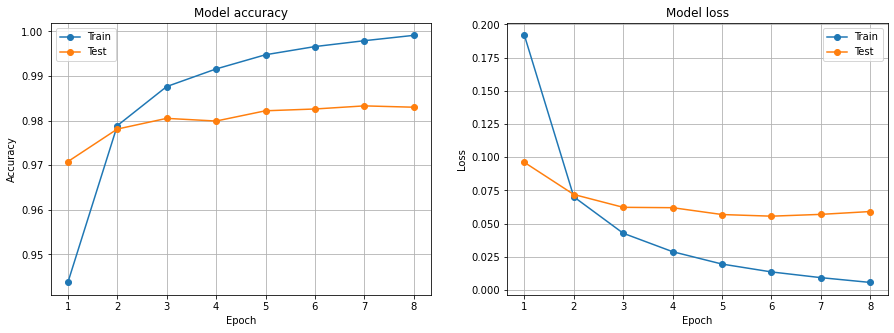

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',  # the parameter to monitor
                  mode='min',          # the parameter is suspposed to decrese
                  patience=2,          # accept that 'val_loss' increases twice
                  restore_best_weights=True,
                  verbose=1)
]

# relod the DNN initial state:
key = 'dense-1_init'
model.load_weights(os.path.join('weights', key))

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 epochs=15, 
                 batch_size=128, 
                 callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 8 - Save the trained DNN

The **weights** or **the structure and weights** of a trained network can be saved in a file with the `save_weights` and `save` methods of the `Sequential` class.<br><br>

### Save the weights of the trained DNN:

In [31]:
import os
# Check whether the folder 'weights' exists and create it if needed:
if not os.path.exists("weights"): os.mkdir("weights")

# save the trained DNN weights:
key = 'trained-1_data'
model.save_weights(os.path.join('weights', key))

# Display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/trained-1_data.data-00000-of-00001
weights/trained-1_data.index


### Save the weights AND structure of the trained DNN

The `save` method of the `Sequential` class saves **the structure** and the **weights** of the trained DNN<br>
You can use the `tf.keras.models.load_model` function to re-create the network later and reload its trained weights to exploit it in operational situation.

In [32]:
import os
# Check whether the folder 'models' exists and create it if needed:
if not os.path.exists("models"): os.mkdir("models")

# save the trained DNN structure + wieghts:
key = 'trained-1_model'
model.save(os.path.join('models', key) )

# Display the created files:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/trained-1_model/assets


INFO:tensorflow:Assets written to: models/trained-1_model/assets


models/trained-1_model


### Further work:
You can now load the `ML3_DNN_cont.ipynb` notebook to learn how to exploit the DNN you have just rained.

## Other interesting resources... videos:

In [33]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [34]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [35]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>